## **Clean Food, Clear Growth: Restaurant Hygiene & Business Success in NYC**

**Goal:** To analyze the relationship between restaurant inspection scores/grades and their survival in NYC's competitive food landscape.



In [6]:
# installing lifelines library
!pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=f82817bcbbc8de83882dabfbd6b922d06f9a7bf230d28a245d559c35d07ebd5c
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [80]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
#enable inline plotting
%matplotlib inline
import numpy as np
import requests
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
# import KaplanMeierFitter
import lifelines
from lifelines import KaplanMeierFitter

In [81]:
#make the api request for Restaurant Inspection Analysis
try:
    #Define the API URL and the date filter parameters
    api_url = 'https://data.cityofnewyork.us/resource/43nn-pn8j.json'
    rows = 1000000
    offset = 0
    params = {
        '$offset': offset,
        '$limit': rows
    }
    response = requests.get(api_url, params=params)
    response.raise_for_status()  # Raise an error for failed requests
    data = response.json()

    if not data:
        print("No data returned. The filter might be incorrect or unsupported.")
    else:
       df = pd.DataFrame(data)
       display(df.head())

#cast errors
except requests.exceptions.RequestException as req_err:
    print(f"A request error occurred: {req_err}")
    print(response.text)  # Print response text for further debugging

except Exception as err:
    print(f"A general error occurred: {err}")
df.shape

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
0,40605319,42ND STREET PIZZA DINER,Manhattan,647,WEST 42 STREET,10036,2125944312,American,2021-07-22T00:00:00.000,Violations were cited in the following area(s).,...,2025-06-24T06:00:13.000,Cycle Inspection / Initial Inspection,40.76153260106,-73.999996390196,104,03,012900,1027089,1010900010,MN15
1,50034742,BLUJEEN,Manhattan,2143,FREDERICK DOUGLASS BOULEVARD,NaN,2122561073,American,2018-02-23T00:00:00.000,No violations were recorded at the time of thi...,...,2025-06-24T06:00:15.000,Administrative Miscellaneous / Re-inspection,0,0,NaN,NaN,NaN,NaN,1,NaN
2,50131655,LIBERTY BAGELS,Manhattan,32,BROADWAY,10004,5164583408,Bagels/Pretzels,2023-02-17T00:00:00.000,Violations were cited in the following area(s).,...,2025-06-24T06:00:13.000,Pre-permit (Non-operational) / Initial Inspection,40.706038204921,-74.013096243331,101,01,000900,1078979,1000220017,MN25
3,50070479,MIRAJ HEALTHY GRILL,Manhattan,120,EAST 34 STREET,10016,2126962818,Mediterranean,2022-04-13T00:00:00.000,Violations were cited in the following area(s).,...,2025-06-24T06:00:13.000,Cycle Inspection / Initial Inspection,40.74665432138,-73.980359852787,105,02,007200,1018513,1008890068,MN20
4,50048478,PLAZA CAFE,Queens,11833,QUEENS BLVD,11375,6466628654,American,2023-06-20T00:00:00.000,Violations were cited in the following area(s).,...,2025-06-24T06:00:13.000,Cycle Inspection / Initial Inspection,40.714904921416,-73.831933646181,406,29,075701,4052811,4022700041,QN17


(283742, 26)

In [82]:
print(df['grade'].value_counts())

grade
A    94688
B    16822
C    11476
N     8482
Z     5088
P      914
Name: count, dtype: int64


In [83]:
# Check null values
df.isnull().sum()

,0
camis,0
dba,1
boro,0
building,316
street,0
zipcode,2819
phone,6
cuisine_description,3281
inspection_date,0
action,3281


In [84]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283742 entries, 0 to 283741
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   camis                  283742 non-null  object
 1   dba                    283741 non-null  object
 2   boro                   283742 non-null  object
 3   building               283426 non-null  object
 4   street                 283742 non-null  object
 5   zipcode                280923 non-null  object
 6   phone                  283736 non-null  object
 7   cuisine_description    280461 non-null  object
 8   inspection_date        283742 non-null  object
 9   action                 280461 non-null  object
 10  violation_code         278446 non-null  object
 11  violation_description  278446 non-null  object
 12  critical_flag          283742 non-null  object
 13  score                  268624 non-null  object
 14  grade                  137470 non-null  object
 15  

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
count,283742,283741,283742,283426,283742,280923,283736,280461,283742,280461,...,283742,280461,283352,283352,280348,280371,280371,278987,283167,280348
unique,30227,24268,6,7609,2456,237,26876,89,1795,5,...,3,33,24343,24343,68,51,1183,21021,20665,193
top,40365904,DUNKIN,Manhattan,1,BROADWAY,10003,2126159700,American,1900-01-01T00:00:00.000,Violations were cited in the following area(s).,...,2025-06-24T06:00:13.000,Cycle Inspection / Initial Inspection,0,0,105,03,087100,4000000,1,MN17
freq,79,3277,104849,1393,10903,6444,167,45105,3281,265626,...,279966,152086,2819,2819,21596,23355,2656,1294,1916,16163


In [85]:
#print columns
df.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description', 'critical_flag', 'score', 'grade',
       'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude',
       'community_board', 'council_district', 'census_tract', 'bin', 'bbl',
       'nta'],
      dtype='object')

In [86]:
print(df.dtypes) #printing data types

camis                    object
dba                      object
boro                     object
building                 object
street                   object
zipcode                  object
phone                    object
cuisine_description      object
inspection_date          object
action                   object
violation_code           object
violation_description    object
critical_flag            object
score                    object
grade                    object
grade_date               object
record_date              object
inspection_type          object
latitude                 object
longitude                object
community_board          object
council_district         object
census_tract             object
bin                      object
bbl                      object
nta                      object
dtype: object


In [87]:
# Converting data types
df['camis'] = df['camis'].astype(str)
df['zipcode'] = df['zipcode'].astype(str)
df['phone'] = df['phone'].astype(str)

# convert dates
df['inspection_date']= pd.to_datetime(df['inspection_date'], errors='coerce')
df['record_date'] = pd.to_datetime(df['record_date'], errors='coerce')
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df.dropna(subset=['inspection_date'], inplace=True)

# convert to numeric colums
df['score'] = pd.to_numeric(df['score'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')


In [88]:
# drop unnecessary colums
drop_cols=['community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'grade_date']
df.drop(columns=drop_cols, inplace=True)


In [89]:
df.isnull().sum()

,0
camis,0
dba,1
boro,0
building,316
street,0
zipcode,0
phone,0
cuisine_description,3281
inspection_date,0
action,3281


In [90]:
# Remove rows with inspection_date = '1900-01-01' (uninspected)
df = df[df['inspection_date'] != '1900-01-01']

In [91]:
# impute fill missing values
cat_mode_cols=['zipcode', 'cuisine_description', 'inspection_type', 'action']
for col in cat_mode_cols:
    mode_val = df[col].mode(dropna=True).iloc[0]
    df[col].fillna(mode_val, inplace=True)

# fill dba, phone, building with mode
df['dba'].fillna(df['dba'].mode()[0], inplace=True)
df['phone'].fillna(df['phone'].mode()[0], inplace=True)
df['building'].fillna(df['building'].mode()[0], inplace=True)
df['street'].fillna(df['street'].mode()[0], inplace=True)

# fill violation code with unknown
df['violation_code'].fillna('Unknown', inplace=True)
df['violation_description'].fillna('Unknown', inplace=True)

# fill score with median
df['score'].fillna(df['score'].median(), inplace=True)


# impute with mean
df['latitude'].fillna(df['latitude'].mean(), inplace=True)
df['longitude'].fillna(df['longitude'].mean(), inplace=True)

df.isnull().sum()


/tmp/ipython-input-91-2571928971.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)
/tmp/ipython-input-91-2571928971.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,0
camis,0
dba,0
boro,0
building,0
street,0
zipcode,0
phone,0
cuisine_description,0
inspection_date,0
action,0


In [92]:
# Standardize grade values
df['grade'] = df['grade'].replace({
    'Not Graded': 'N',
    'PENDING': 'Z',  # if you had pending labeled this way too
    'Not Yet Graded': 'N'  # just in case this string came in
})

In [93]:
print(df['grade'].value_counts())

grade
A    94688
B    16822
C    11476
N     8482
Z     5088
P      914
Name: count, dtype: int64


# **Merge and Group**

First and Last Inspection Dates

In [94]:
# Group by 'camis' and compute first and last inspection dates
df_survival = df.groupby('camis')['inspection_date'].agg(['min', 'max']).reset_index()

# Rename columns
df_survival.columns = ['camis', 'first_inspection', 'last_inspection']

# Calculate the number of active days
df_survival['active_days'] = (df_survival['last_inspection'] - df_survival['first_inspection']).dt.days

Most Recent Grade

In [95]:
# latest grade, cuisine, boro, score per restaurant
latest_inspections = df.sort_values('inspection_date').groupby('camis').tail(1)

# Merge relevant fields into df_survival
df_survival = df_survival.merge(
    latest_inspections[['camis', 'grade', 'cuisine_description', 'boro', 'score']],
    on='camis',
    how='left'
)

In [96]:
valid_grades = ['A', 'B', 'C', 'Z', 'N', 'P']
df['grade'] = df['grade'].where(df['grade'].isin(valid_grades), 'N')

# **# Explatory Data Analysis (EDA)**

Do restaurants with Grade A stay active longer than B or C?

In [97]:
# print grade values and counts
print(df_survival['grade'].value_counts())

grade
A    18719
N     1827
B     1249
Z      844
C      167
Name: count, dtype: int64


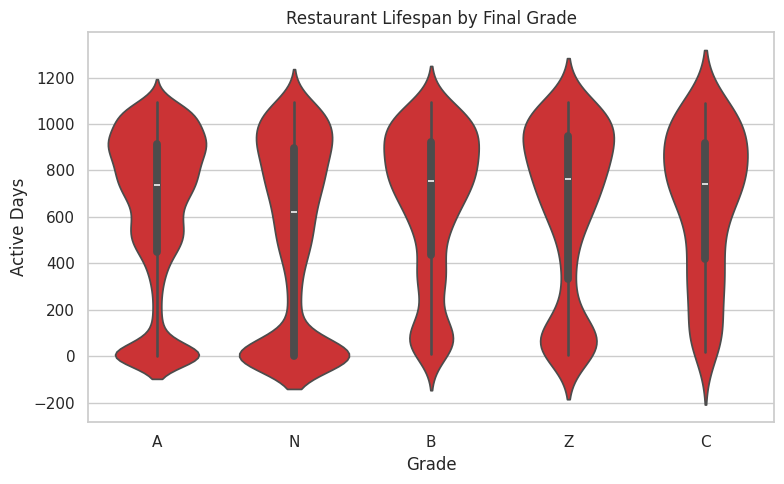

In [98]:
# Lifespan Calculation
# Group by restaurant ID
grouped = df.groupby('camis')
df_survival = grouped['inspection_date'].agg(['min', 'max']).reset_index()
df_survival.columns = ['camis', 'first_inspection', 'last_inspection']
df_survival['active_days'] = (df_survival['last_inspection'] - df_survival['first_inspection']).dt.days

# Merge grade and additional info
df_latest = df.sort_values('inspection_date').groupby('camis').tail(1)
df_survival = df_survival.merge(df_latest[['camis', 'grade', 'boro', 'score', 'cuisine_description']], on='camis', how='left')

# Visualizations & EDA
# Violin Plot: Active Days by Grade
plt.figure(figsize=(8, 5))
sns.violinplot(data=df_survival, x='grade', y='active_days')
plt.title("Restaurant Lifespan by Final Grade")
plt.xlabel("Grade")
plt.ylabel("Active Days")
plt.tight_layout()
plt.show()

This plot shows the distribution of how long restaurants stayed open, grouped by final inspection grade.

**Key Finding:**  
- All grades show a bimodal distribution, especially noticeable in Grade A and N, with one cluster of restaurants closing early and another surviving longer.
- Grade A, B, and Z show similar upper distribution with median lifespans aound 700-800 days.
- Grade N has a notable low end tail, compared to the rest this might be due to many restaurants closed shortly after being graded.
- Grade C shows a slightly shorter median compared to A, B, and Z but not drastically different.


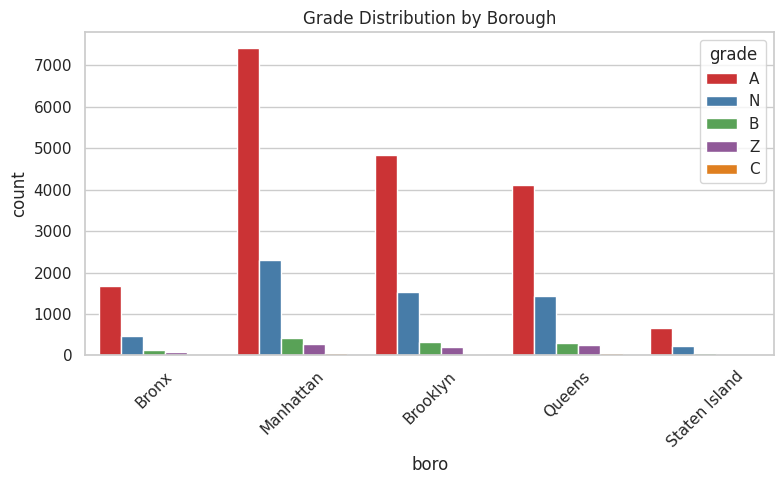

In [99]:
# Bar Plot: Grade Distribution by Borough
plt.figure(figsize=(8, 5))
sns.countplot(data=df_survival, x='boro', hue='grade')
plt.title("Grade Distribution by Borough")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Comparing grade distribution across NYC boroughs.  

**Key Finding:**  
- Grade A dominates across all boroughs, this indicates that majority of restaurants maintain high standards.
- Manhattan has the highest restaurant count overall, followed by Brooklyn and Queens.
- Lowest grades (B, C, Z) appear more frequently in large boroughs such as Manhattan and Brooklyn.
- Staten Island has the lowest restaurant count.

This charts shows that larger boroughs have both more restaurants and more variance in grades. Such as grade A is the most common grade across the board, suggesting a generally high level of compliance citywide.

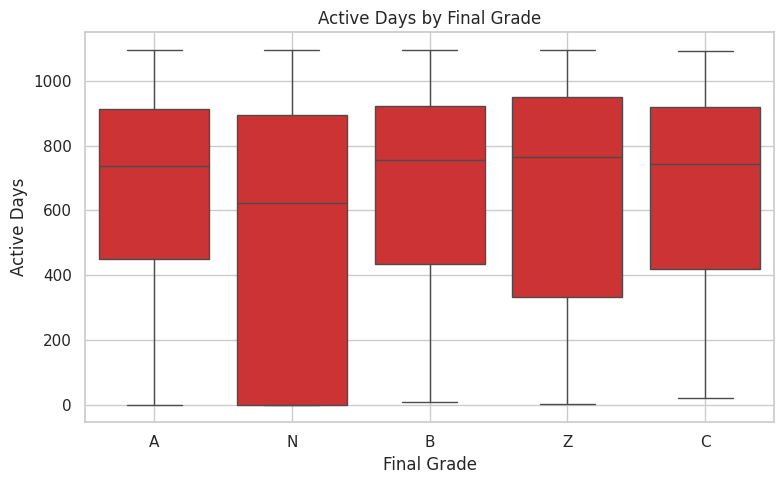

In [100]:
plt.figure(figsize=(8, 5))

sns.boxplot(
    data=df_survival[df_survival['grade'].isin(['A', 'B', 'C', 'Z', 'N', 'Not Graded'])],
    x='grade',
    y='active_days'
)

plt.title("Active Days by Final Grade")
plt.xlabel("Final Grade")
plt.ylabel("Active Days")
plt.grid(True)
plt.tight_layout()
plt.show()

Statistical summary of restaurant lifespan (active days) distribution by final grade.  

**Key Finding:**  
- Median active days are similar across A, B and Z grades (750 days)
- Grade N (Not Graded) shows a much wider and more skewed range showing many short lived restaurants.
- Outliers are present in every category, especially N an Z grades, indicating highly variable lifespans.

Final grades are not strongly predictive of how long a restaurant survives, except for grade N, which is linked with early exits. It could be either early closures before receiving a final grade.

Are some cuisines more prone to poor grades or shorter lifespans?

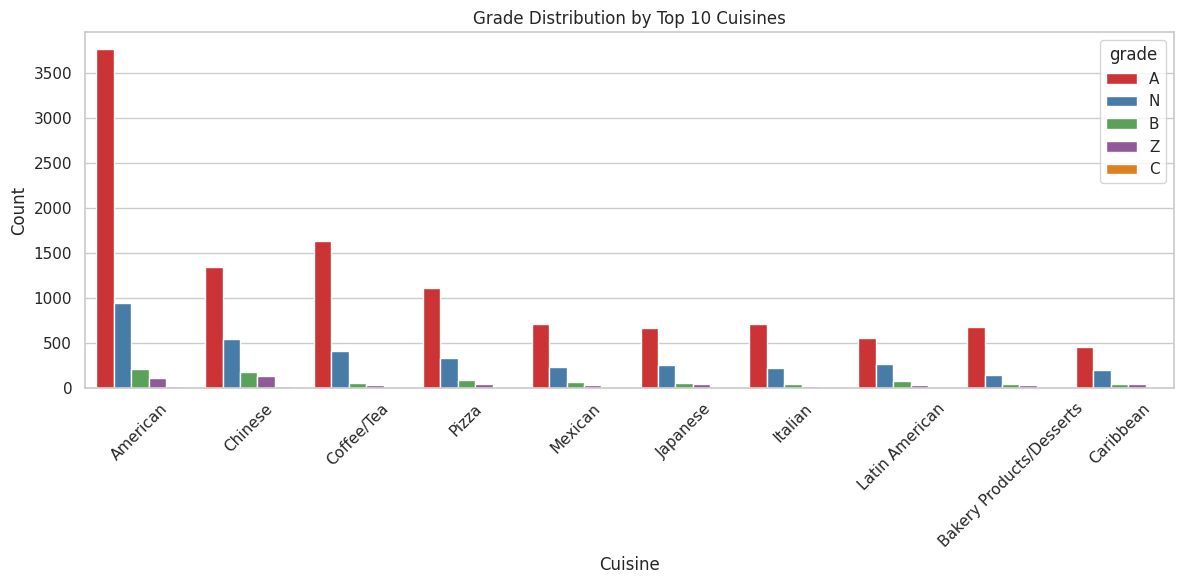

In [101]:
# Get top 10 most common cuisines
top_cuisines = df_survival['cuisine_description'].value_counts().head(10).index

# Filter dataset to only those cuisines
cuisine_grade = df_survival[df_survival['cuisine_description'].isin(top_cuisines)]

# Plot grade distribution
plt.figure(figsize=(12, 6))
sns.countplot(
    data=cuisine_grade,
    x='cuisine_description',
    hue='grade',
    order=top_cuisines
)
plt.title("Grade Distribution by Top 10 Cuisines")
plt.xlabel("Cuisine")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This chart visualizes how grades are distributed among the top 10 popular cuisine types.

**Key Findings:**
- Among the top ten cuisines American cusine leads Grade A awards.
- Chinese and Coffee/Tea cuisines have substantial numbers of N and Z grades.
- Pizza and Latin American cuisine shows relatively high occurences of B grades following with Mexican cuisine.

Certain cuisines like Latin American, Chinese, Pizza, Mexican may be more scrutinized or face operational challenges, resulting in more varied grades.

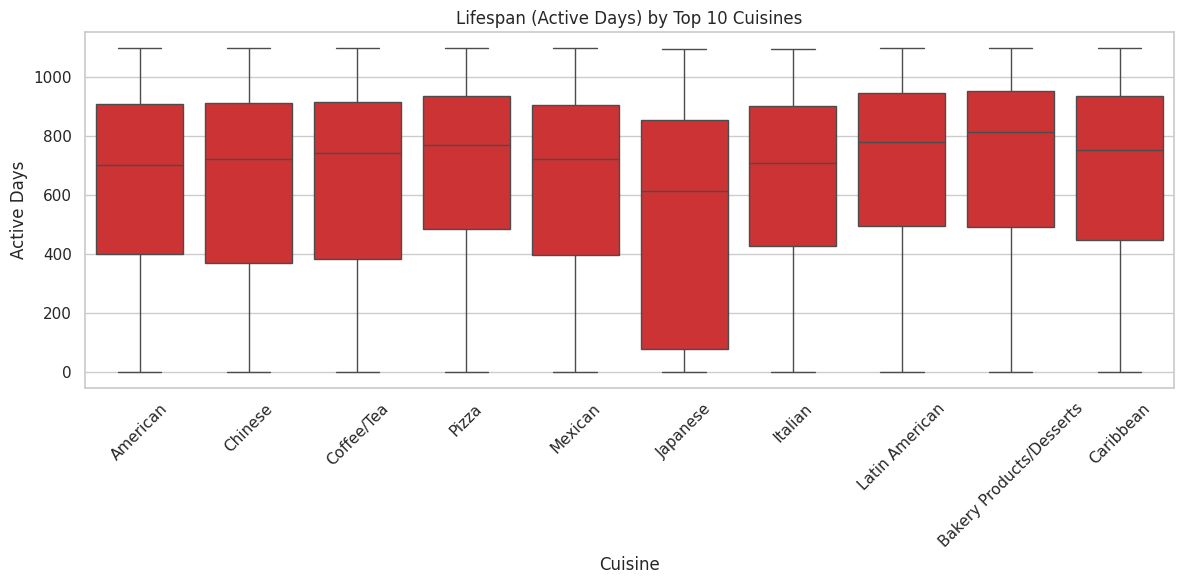

In [102]:
# lifespan by cuisine (active days)
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=cuisine_grade,
    x='cuisine_description',
    y='active_days',
    order=top_cuisines
)
plt.title("Lifespan (Active Days) by Top 10 Cuisines")
plt.xlabel("Cuisine")
plt.ylabel("Active Days")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This plot compares the active days of restaurants grouped by cuisines.

**Key Findings:**
- Most cuisines have similar median lifespans from 700 - 800 days
- Japanese cuisine shows a significantly wider range and lower median lifespan.
- Latin American, Bakery, Pizza, and Caribbean cuisines shows slightly higher median lifespans.

Cuisines may have modest effects on longevity, but external factors likely play a larger role. Japanese restaurants may face unique operational or other external challenges compared to the rest of the cuisines.

How does restaurant lifespan differ across boroughs?

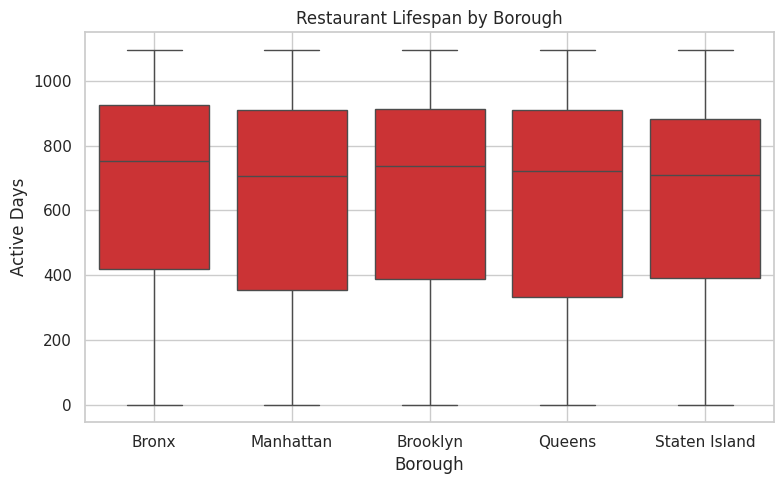

In [103]:
plt.figure(figsize=(8, 5))

sns.boxplot(data=df_survival, x='boro', y='active_days')

plt.title("Restaurant Lifespan by Borough")
plt.xlabel("Borough")
plt.ylabel("Active Days")
plt.grid(True)
plt.tight_layout()
plt.show()

Here I am comparing the distribution of restaurant lifespans by borough.

**Key Findings:**
- Median lifespan are similar across boroughs 750-775 days
- Bronx shows a slightly higher median and upper quartile, compared to other boroughs this suggest slighly longer lasting establishments.
- All boroughs show significant variability.
- Manhattan has slightly shorter lifespans could be because of higher costs and turnover.

Lifespan is broadly consistent citiwide but Bronx restaurants tend to survive longer, followed by Brooklyn and Queens. All differences may relate more to local economies like rent rather than policy or inspection.

In [105]:
# ANOVA
from scipy.stats import f_oneway

# Group by borough and collect scores
borough_lifespans = [group['active_days'].dropna() for _, group in df_survival.groupby('boro')]

anova_stat, anova_p = f_oneway(*borough_lifespans)
print(f"ANOVA result: F = {anova_stat:.2f}, p-value = {anova_p:.4f}")

ANOVA result: F = 5.60, p-value = 0.0002


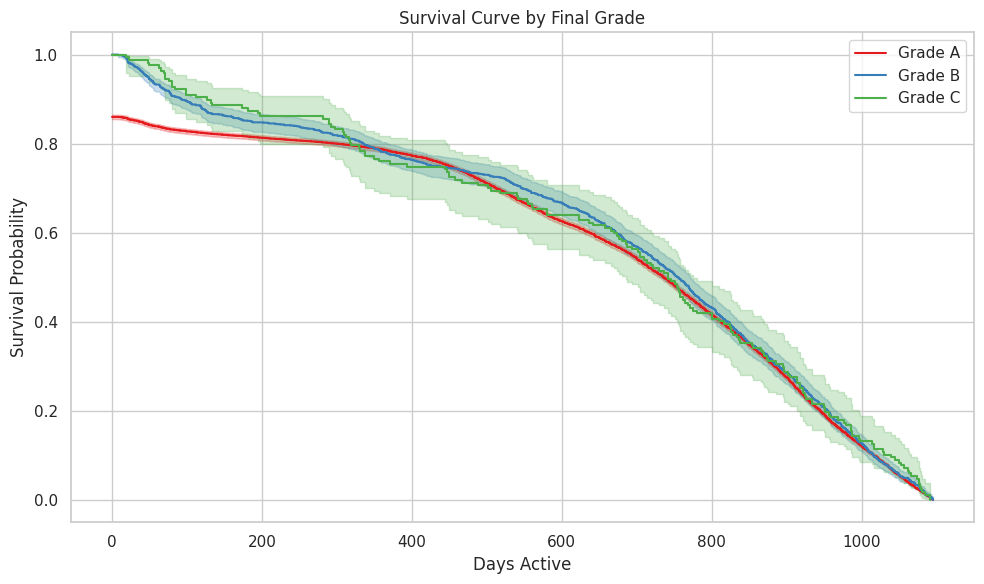

In [106]:
# Survival Curve by Grade
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for grade in ['A', 'B', 'C']:
    mask = df_survival['grade'] == grade
    kmf.fit(durations=df_survival[mask]['active_days'], label=f'Grade {grade}')
    kmf.plot_survival_function()
plt.title('Survival Curve by Final Grade')
plt.xlabel('Days Active')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

Kaplan Meier curve model shows the survival probability of restaurants over time by final grade.

**Key Findings:**
- Grade B and C restaurants suprisingly have slighly higher survival probabilities in early years compared to Grade A.
- Grade A starts lower and catches up with others over time.
- Over 1000 days, surival drops below 20% for all grades.

Grades may not be strong predictors of longevity. Because other factors like business management and other factors likely play a more decisive rolelikely play a more decisive roles.

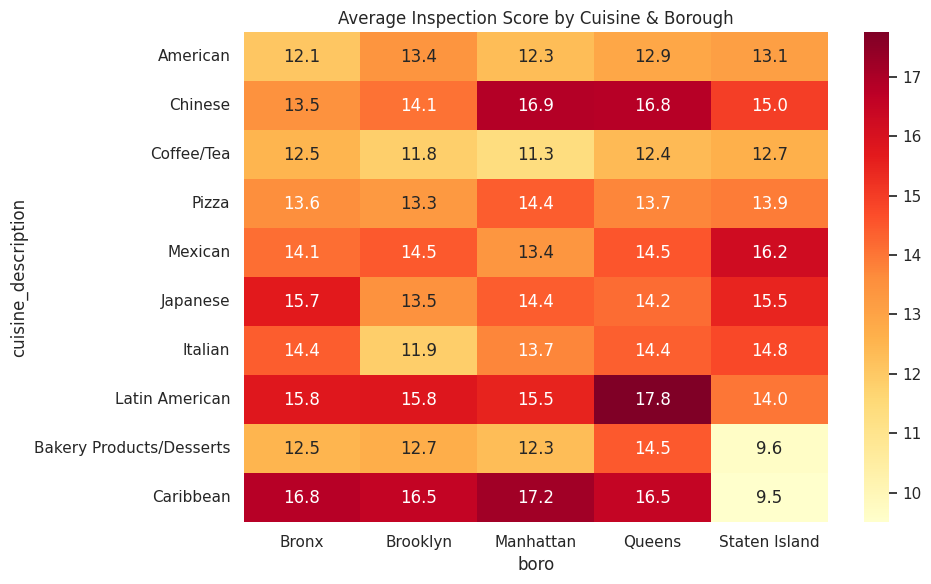

In [107]:
# Heatmap: Cuisine vs Borough Scores
pivot = df_survival.pivot_table(
    index='cuisine_description',
    columns='boro',
    values='score',
    aggfunc='mean'
).loc[top_cuisines]
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Average Inspection Score by Cuisine & Borough")
plt.tight_layout()
plt.show()

This heatmap shows the average inspection score by cuisine and borough.

**Key Findings:**
- Caribbean, Latin American and Chinese cuisines show higher (worse) average scores, particularly in Bronx, Brooklyn, Manhattan, and Queens.
- American and Coffee/Tea cuisines tend to have better scores across boroughs.
- Queens shows the highest average score for Latin American is 17.8 highest.

Inspection scores vary by both cuisine and location. Certain combinations like Caribbean in Manhattan received second highest score of 17.2.

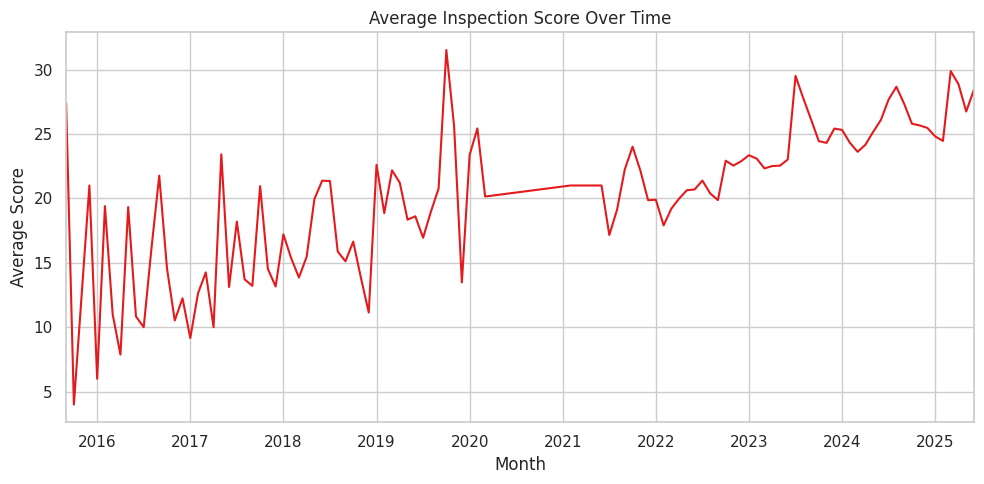

In [108]:
# Score Trend Over Time
df['year_month'] = df['inspection_date'].dt.to_period('M')
monthly_scores = df.groupby(['year_month'])['score'].mean()
monthly_scores.plot(figsize=(10, 5))
plt.title('Average Inspection Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.grid(True)
plt.tight_layout()
plt.show()

This trend line shows how inspection scores have changed over time. Higher score = worse.

**Key Findings:**
- Early years like 2016 - 2018 show high fluctuation in scores.
- From 2019 scores are generally increasing which indicates worsening conditions or stricter inspections has become.
- Peaks in 2020 and again post 2022 may reflect operational strain caused by pandemic.

Inspection quality or restaurant compliance has worsened over time. This could signal need for policy changes or support for struggling sectors.

# *Hypothesis Testing*

Do Grade A restaurants stay open significantly longer than others?

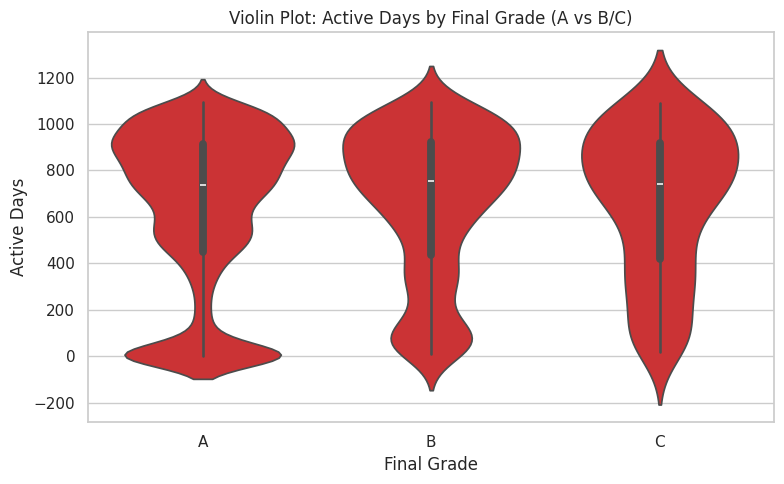

In [109]:
# T-test groups
group_A = df_survival[df_survival['grade'] == 'A']['active_days'].dropna()
group_BC = df_survival[df_survival['grade'].isin(['B', 'C'])]['active_days'].dropna()
t_stat, p_val = ttest_ind(group_A, group_BC, equal_var=False)

# Violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=df_survival[df_survival['grade'].isin(['A', 'B', 'C'])], x='grade', y='active_days')
plt.title("Violin Plot: Active Days by Final Grade (A vs B/C)")
plt.xlabel("Final Grade")
plt.ylabel("Active Days")
plt.tight_layout()
plt.show()

This violin plot will compare the distribution of active days for restaurants with final grades A, B, and C.

**Key Findings:**
- Grade A and B restaurants show very similar lifespan distributions. Both have bimodal shapes with peaks around low active days and anotehr around 900 - 1000 days.
- Grade C restaurants show a slightly broader base with more short-lived outliers, but their median and upper distribution closely resemble A and B.
- There is no strong differentiation in median or overall lifespan across grades.

The assumption that Grade A restaurants survive significantly longer is not supported here. In fact, Grades B and C follow comparable patterns, suggesting that final inspection grades may not be a reliable predictor of business longevity.

 Are certain cuisines more likely to get lower grades?

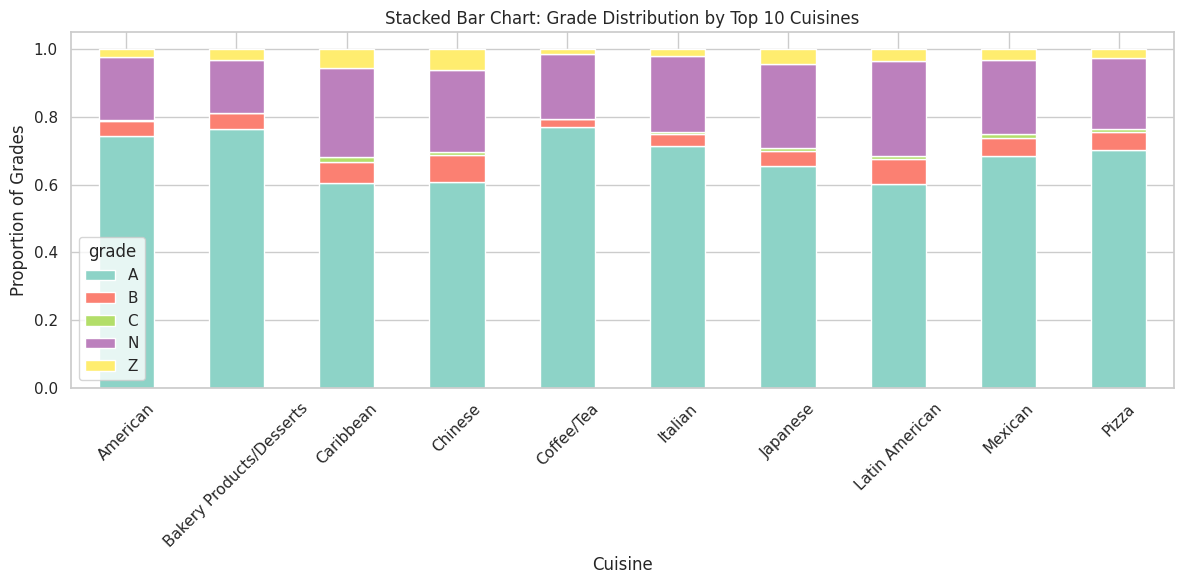

In [110]:
# Chi-Square Test: Cuisines vs Grades
# Top 10 cuisines and crosstab
top_cuisines = df_survival['cuisine_description'].value_counts().head(10).index
cuisine_grade = df_survival[df_survival['cuisine_description'].isin(top_cuisines)]
crosstab = pd.crosstab(cuisine_grade['cuisine_description'], cuisine_grade['grade'])
chi2, chi_p, dof, expected = chi2_contingency(crosstab)

# Stacked bar chart
crosstab.div(crosstab.sum(axis=1), axis=0).plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='Set3'
)
plt.title("Stacked Bar Chart: Grade Distribution by Top 10 Cuisines")
plt.xlabel("Cuisine")
plt.ylabel("Proportion of Grades")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This stacked chart shows the relative proportions of grades (A, B, C, N, Z) within each of the top 10 cuisine types.

**Key Findings:**
- Coffee/Tea, Bakery and American cuisines have the highest proportion of Grade A restaurants >75%
- Grade C is relatively rare across all cuisines except Mexica, Pizza and Carribean cuisines.
- The distribution is skewed in some cuisines toward more incomplete inspections like N and Z possibly due to restaurant closures or other regulatory issues.

Certain cuisines may face challenges in reaching final grading, or may have more frequent closures. These differences could reflect disparities in resources, compliance or business stability.

 Do average scores vary significantly between boroughs or cuisines?

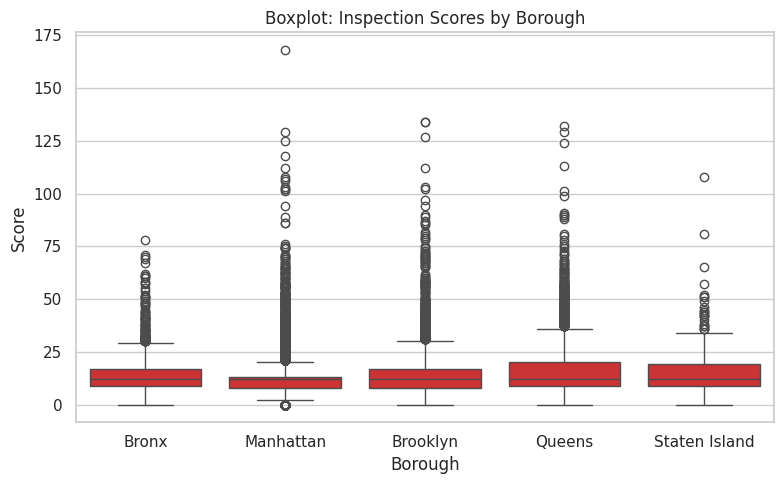

In [111]:
# ANOVA: Scores by Borough
borough_groups = [group['score'].dropna() for _, group in df_survival.groupby('boro')]
anova_stat, anova_p = f_oneway(*borough_groups)

# Boxplot of scores by borough
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_survival, x='boro', y='score')
plt.title("Boxplot: Inspection Scores by Borough")
plt.xlabel("Borough")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

This boxplot chart shows the spread of inspection scores by borough. Lower scores are better, with higher scores indicating more violations.

**Key Findings:**
- Median inspection scores are relatively similar across boroughs around 12-14 this suggest consistency on enforcement.
- Outliers are very high scores are present in all boroughs but are more frequient in Brooklyn and Queens this indicates more instance of severe violations.
- Staten Island has a narrower spread, possibly due to fewer restaurants and/or lower inspection frequency.

Inspection score variance is broadly citywide with only minor differences between boroughs. The large number of high score outliers suggests some systemic compliance issues.

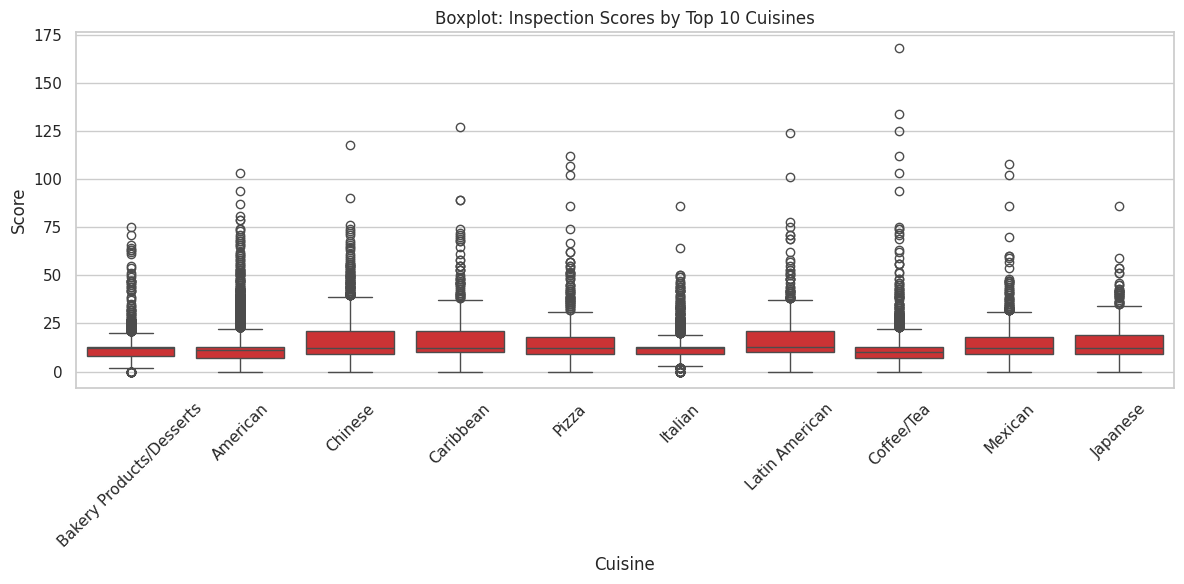

In [112]:
# ANOVA: Scores across top 10 cuisines
# Reuse cuisine_grade
cuisine_groups = [
    group['score'].dropna()
    for _, group in cuisine_grade.groupby('cuisine_description')
]
anova_stat_cuisine, anova_p_cuisine = f_oneway(*cuisine_groups)

# Boxplot of scores by cuisine
plt.figure(figsize=(12, 6))
sns.boxplot(data=cuisine_grade, x='cuisine_description', y='score')
plt.title("Boxplot: Inspection Scores by Top 10 Cuisines")
plt.xlabel("Cuisine")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This boxplot analyzes inspection score distribution across the 10 most common cuisines.

**Key Findings:**
- Italian and Coffee/Tea cuisines have lower median scores, suggesting better sanitary conditions.
- Caribbean, Latin American, and Chinese cuisines have higher median scores and more high score outliers, indicating mroe frequent or severe violations.
- All cuisines shows significant variablity with wide ranges and many outliers.

Cuisine type may be correlated with inspection outcomes, fox example due to operational complexity, cultural practices, or resource constraints.

In [113]:
df_survival['year_opened'] = df_survival['first_inspection'].dt.year
df_survival['duration_group'] = pd.cut(df_survival['active_days'], bins=[0, 365, 730, 1095, 5000], labels=["<1yr", "1-2yr", "2-3yr", "3yr+"])

In [114]:
print("\n--- Hypothesis Testing Results ---")
print(f"5.1 T-test (Grade A vs B/C):              t-stat = {t_stat:.2f},     p-value = {p_val:.4f}")
print(f"5.2 Chi-Square (Cuisine vs Grade):        chi² = {chi2:.2f},        p-value = {chi_p:.4f}")
print(f"5.3 ANOVA (Score by Borough):             F-stat = {anova_stat:.2f}, p-value = {anova_p:.4f}")
print(f"5.4 ANOVA (Score by Top 10 Cuisines):     F-stat = {anova_stat_cuisine:.2f}, p-value = {anova_p_cuisine:.4f}")


--- Hypothesis Testing Results ---
5.1 T-test (Grade A vs B/C):              t-stat = -3.26,     p-value = 0.0011
5.2 Chi-Square (Cuisine vs Grade):        chi² = 407.75,        p-value = 0.0000
5.3 ANOVA (Score by Borough):             F-stat = 25.47, p-value = 0.0000
5.4 ANOVA (Score by Top 10 Cuisines):     F-stat = 39.42, p-value = 0.0000


In [115]:
# Save dataframes to CSV for Power BI dashboard use

# 1. Raw inspection data
df.to_csv("inspections_raw.csv", index=False)

# 2. Latest inspection per restaurant
restaurant_latest = df.sort_values('inspection_date').groupby('camis').tail(1)
restaurant_latest.to_csv("restaurant_latest.csv", index=False)

# 3. Restaurant-level survival summary
df_survival.to_csv("restaurant_survival.csv", index=False)

# 4. Monthly average scores
monthly_scores_df = monthly_scores.reset_index()
monthly_scores_df.columns = ['year_month', 'avg_score']
monthly_scores_df.to_csv("monthly_scores.csv", index=False)

# 5. Cuisine vs Borough average scores (heatmap)
score_cuisine_boro = pivot.reset_index()
score_cuisine_boro.to_csv("score_cuisine_boro.csv", index=False)